# Efficiently run SetFit Models with Optimum

In [1]:
# To reproduce this notebook's results, launch it using `numactl` to gain better control on which resources you are running. 
# It is best to run on a single socket (`-m 0`):

# NUM_THREADS=<NUM_AVAILABLE_CORES>
# OMP_NUM_THREADS=$NUM_THREADS numactl -C 0-"$(($NUM_THREADS-1))" -m 0 jupyter notebook

## Setup
This notebook requires `matplotlib` for plotting results, install by running:

In [ ]:
!python -m pip install matplotlib -qqq

If you're running this Notebook on Colab or some other cloud platform, you will need to install the `setfit` library. Uncomment the following cell and run it:

In [2]:
# !python -m pip install setfit matplotlib -qqq

## 1. Benchmark SetFit using PyTorch

Define the infrastructure for conducting latency, throughput and accuracy benchmarks, as well as a plotting function for the results.

In [15]:
from pathlib import Path
from time import perf_counter
import os
import warnings

import evaluate
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd

warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"

class PerformanceBenchmark:
    def __init__(self, model, dataset, optim_type, metric="accuracy", model_path=None):
        self.model = model
        self.dataset = dataset
        self.optim_type = optim_type
        self.enable_autocast = 'optimum' in self.optim_type.lower()
        self.metric = evaluate.load(metric)
        self.model_path = model_path
        
    def compute_accuracy(self):
        with torch.cpu.amp.autocast(enabled=self.enable_autocast):
            preds = self.model.predict(self.dataset["text"])
        labels = self.dataset["label"]
        accuracy = self.metric.compute(predictions=preds, references=labels)
        print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
        return accuracy

    def compute_size(self):
        if self.model_path is None:
            state_dict = self.model.model_body.state_dict()
            tmp_path = Path("model.pt")
            torch.save(state_dict, tmp_path)
            # Calculate size in megabytes
            size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
            # Delete temporary file
            tmp_path.unlink()
        else:
            size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
        print(f"Model size (MB) - {size_mb:.3f}")
        return {"size_mb": size_mb}

    def compute_latency(self, query="that loves its characters and communicates something rather beautiful about human nature"):
        latencies = []
        # Warmup
        for _ in range(10):
            with torch.no_grad(), torch.cpu.amp.autocast(enabled=self.enable_autocast):
                _ = self.model([query])
        # Timed run
        for _ in range(200):
            start_time = perf_counter()
            with torch.no_grad(), torch.cpu.amp.autocast(enabled=self.enable_autocast):
                _ = self.model([query])
            latency = perf_counter() - start_time
            latencies.append(latency)
        # Compute run statistics
        time_avg_ms = 1000 * np.mean(latencies)
        time_std_ms = 1000 * np.std(latencies)
        print(rf"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
        return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

    def compute_throughput(self, batch_sizes=[64, 512, 8192]):
        results = {}
        num_iters = 5
        replications = int((max(batch_sizes) * (num_iters + 1)) / len(self.dataset))
        replicated_ds = (self.dataset["text"] * replications)[:max(batch_sizes) * num_iters]

        for batch_size in batch_sizes:
            throughputs = []
            # Warmup
            dataloader = iter(DataLoader(replicated_ds, batch_size=batch_size))
            for _ in range(2):
                with torch.no_grad(), torch.cpu.amp.autocast(enabled=self.enable_autocast):
                    _ = self.model(next(dataloader))
            # Timed run
            dataloader = iter(DataLoader(replicated_ds, batch_size=batch_size))
            num_loops = int(num_iters * (max(batch_sizes) / batch_size))
            for _ in range(num_loops):
                start_time = perf_counter()
                with torch.no_grad(), torch.cpu.amp.autocast(enabled=self.enable_autocast):
                    self.model(next(dataloader))
                total_time =  perf_counter() - start_time
                throughputs.append(batch_size / total_time)
                
            # Compute run statistics
            avg_throughput = np.mean(throughputs)
            std_throughput = np.std(throughputs)
            print(rf"Average throughput with {batch_size=} (samples/second): {avg_throughput:.2f} +\- {std_throughput:.2f}")
            results[f"throughput_avg_{batch_size}"] = avg_throughput
            results[f"throughput_std_{batch_size}"] = std_throughput
        return results
        
    def run_benchmark(self):
        all_metrics = {}
        for run_metric in self.compute_size, self.compute_accuracy, self.compute_latency, self.compute_throughput:
            all_metrics |= run_metric()
        return {self.optim_type: all_metrics}
        

def plot_metrics(perf_metrics):
    df = pd.DataFrame.from_dict(perf_metrics, orient="index")

    for idx in df.index:
        df_opt = df.loc[idx]
        plt.errorbar(
            df_opt["time_avg_ms"],
            df_opt["accuracy"] * 100,
            xerr=df_opt["time_std_ms"],
            fmt="o",
            alpha=0.5,
            ms=df_opt["size_mb"] / 15,
            label=idx,
            capsize=5,
            capthick=1,
        )

    legend = plt.legend(loc="lower right")

    plt.ylim(63, 95)
    # Use the slowest model to define the x-axis range
    xlim = max([metrics["time_avg_ms"] for metrics in perf_metrics.values()]) * 1.3
    plt.xlim(0, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency with batch_size=1 (ms)")
    plt.show()

Load the dataset for running evaluations:

In [6]:
from datasets import load_dataset
test_dataset = load_dataset("SetFit/sst2")["validation"]

Run the benchmark with the standard PyTorch backend:

Model size (MB) - 127.32
Accuracy on test set - 0.906
Average latency (ms) - 8.50 +\- 0.13
Average throughput with batch_size=64 (samples/second): 701.53 +\- 80.30
Average throughput with batch_size=512 (samples/second): 1086.79 +\- 86.01
Average throughput with batch_size=8192 (samples/second): 1521.53 +\- 11.94


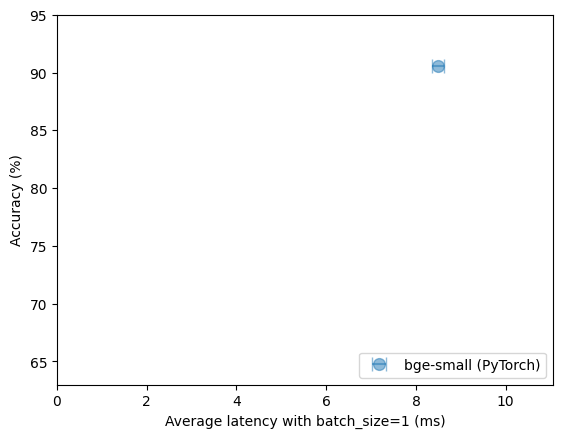

In [7]:
import json
from setfit import SetFitModel

small_model = SetFitModel.from_pretrained("moshew/bge-small-en-v1.5_setfit-sst2-english")
pb = PerformanceBenchmark(model=small_model, dataset=test_dataset, optim_type="bge-small (PyTorch)")
perf_metrics = pb.run_benchmark()

# Save the benchmark results to file
with open("baseline_metrics.json", "w") as f:
    json.dump(perf_metrics, f)
plot_metrics(perf_metrics)

## 2. Optimizing with [`optimum-intel`](https://github.com/huggingface/optimum-intel)

🤗 Optimum Intel is the interface between the 🤗 Transformers and Diffusers libraries and the different tools and libraries provided by Intel to accelerate end-to-end pipelines on Intel architectures.

In order to optimize our SetFit model, we'll use Intel [Neural Compressor](https://www.intel.com/content/www/us/en/developer/tools/oneapi/neural-compressor.html) (`INC`), part of `optimum-intel`. 
We'll use INC to quantize the model body. This will compress the model in size and result in faster inference. 

Let's start by installing the requires dependencies:

In [ ]:
# !python -m pip install torch==2.1 --index-url https://download.pytorch.org/whl/cpu -qqq
# !python -m pip install intel-openmp -qqq
# !python -m pip install --upgrade-strategy eager -qqq optimum[neural-compressor,ipex]

# Install TCMalloc: TCMalloc is Google's customized implementation of C's malloc() and C++'s operator used for memory allocation
# within our C and C++ code. TCMalloc is a fast, multi-threaded malloc implementation.

# On your local machine use conda to install TCMALLOC. Make sure that you launched this notebook inside the conda environment.
conda install gperftools -c conda-forge -y
echo export LD_PRELOAD=${CONDA_PREFIX}/lib/libtcmalloc.so:${CONDA_PREFIX}/lib/libiomp5.so:$LD_PRELOAD >> ~/.bashrc

# On Google Colab, uncomment the following and run to install:
# wget https://github.com/gperftools/gperftools/releases/download/gperftools-2.7.90/gperftools-2.7.90.tar.gz
# tar -xzf gperftools-2.7.90.tar.gz 
# cd gperftools-2.7.90
# ./configure --prefix=$HOME/.local
# make
# make install
# echo export LD_PRELOAD=$HOME/.local/lib/libtcmalloc.so:$LD_PRELOAD >> ~/.bashrc
# echo export LD_PRELOAD=$VIRTUAL_ENV/lib/libiomp5.so:$LD_PRELOAD >> ~/.bashrc

# RESTART KERNEL AND RUN CELL [2] AGAIN
import os
os._exit(00)

Load the Qasper calibration dataset to be used for quantization:

In [15]:
import random
from datasets import Dataset, load_dataset

def load_qasper_calibration_set(sample_size) -> Dataset:
    train_set = load_dataset("allenai/qasper")["train"]
    random.seed(666)
    random_samples = random.sample(range(len(train_set)), sample_size)
    random_queries = [random.sample(train_set[x]["qas"]["question"], 1)[0] for x in random_samples]
    random_abstracts = [train_set[x]["abstract"] for x in random_samples]
    samples = random.sample(random_queries + random_abstracts, sample_size)
    random.shuffle(samples)
    def gen():
        for s in samples:
            yield {"text": s}
    return Dataset.from_generator(gen)

Define the desired quantization process using `optimum.intel`:

In [24]:
from optimum.intel import INCModel, INCQuantizer
from neural_compressor.config import PostTrainingQuantConfig
from transformers import AutoModel, AutoTokenizer

def quantize(model_name, output_path, calibration_set):
    model = AutoModel.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def preprocess_function(examples):
        return tokenizer(examples["text"], padding="max_length", max_length=512, truncation=True)

    vectorized_ds = calibration_set.map(preprocess_function, num_proc=10)
    vectorized_ds = vectorized_ds.remove_columns(["text"])

    quantizer = INCQuantizer.from_pretrained(model)
    quantization_config = PostTrainingQuantConfig(approach="static", backend="ipex", domain="nlp")
    quantizer.quantize(
        quantization_config=quantization_config,
        calibration_dataset=vectorized_ds,
        save_directory=output_path,
        batch_size=1,
    )
    tokenizer.save_pretrained(output_path)

Quantize our SetFit model using `optimum-intel` on 100 samples:

In [5]:
model_name = "moshew/bge-small-en-v1.5_setfit-sst2-english"
calibration_set = load_qasper_calibration_set(sample_size=100)
optimum_model_path = os.path.expanduser(f"~/models/{model_name}_opt")

quantize(model_name, output_path=optimum_model_path, calibration_set=calibration_set)

In [8]:
from setfit.exporters.utils import mean_pooling

class OptimumSetFitModel:
    def __init__(self, inc_model, tokenizer, model_head):
        self.optimum_model = inc_model
        self.tokenizer = tokenizer
        self.model_head = model_head

    def predict(self, inputs):
        encoded_inputs = self.tokenizer(
            inputs, padding=True, truncation=True, return_tensors="pt"
        ).to(self.optimum_model.device)

        outputs = self.optimum_model(**encoded_inputs)
        embeddings = mean_pooling(
            outputs["last_hidden_state"], encoded_inputs["attention_mask"]
        )
        return self.model_head.predict(embeddings.cpu())

    def __call__(self, inputs):
        return self.predict(inputs)

In [9]:
import json
import warnings
import os

import optimum.intel
from transformers import AutoTokenizer
from setfit import SetFitModel
from datasets import load_dataset

warnings.filterwarnings("ignore")

tokenizer = AutoTokenizer.from_pretrained(optimum_model_path, model_max_length=512)
optimum_model = optimum.intel.INCModel.from_pretrained(optimum_model_path)
model = SetFitModel.from_pretrained("moshew/bge-small-en-v1.5_setfit-sst2-english")
optimum_setfit_model = OptimumSetFitModel(optimum_model, tokenizer, model.model_head)

# Reload test dataset
test_dataset = load_dataset("SetFit/sst2")["validation"]

# Perform inference
optimum_setfit_model(test_dataset["text"][:10])

loading configuration file /home/sdp/models/moshew/bge-small-en-v1.5_setfit-sst2-english_opt/inc_config.json
INCConfig {
  "distillation": {},
  "neural_compressor_version": "2.4.1",
  "optimum_version": "1.16.2",
  "pruning": {},
  "quantization": {
    "dataset_num_samples": 100,
    "is_static": true
  },
  "save_onnx_model": false,
  "torch_version": "2.1.2",
  "transformers_version": "4.37.1"
}

intel_extension_for_pytorch version is 2.1.100+cpu
2024-01-29 02:11:29,094 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: moshew/bge-small-en-v1.5_setfit-sst2-english
2024-01-29 02:11:29,253 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device: cpu


array([0, 0, 0, 0, 1, 1, 0, 1, 0, 1])

Model size (MB) - 0.004
Accuracy on test set - 0.904
Average latency (ms) - 3.19 +\- 0.14
Average throughput with batch_size=64 (samples/second): 2401.30 +\- 538.56
Average throughput with batch_size=512 (samples/second): 2624.82 +\- 415.66
Average throughput with batch_size=8192 (samples/second): 5998.49 +\- 248.30

bge-small (PyTorch):
size_mb: 127.324
accuracy: 0.906
time_avg_ms: 8.501
time_std_ms: 0.134
throughput_avg_64: 701.532
throughput_std_64: 80.304
throughput_avg_512: 1086.789
throughput_std_512: 86.014
throughput_avg_8192: 1521.528
throughput_std_8192: 11.943

bge-small (optimum-intel):
size_mb: 0.004
accuracy: 0.904
time_avg_ms: 3.191
time_std_ms: 0.137
throughput_avg_64: 2401.301
throughput_std_64: 538.561
throughput_avg_512: 2624.823
throughput_std_512: 415.663
throughput_avg_8192: 5998.494
throughput_std_8192: 248.296



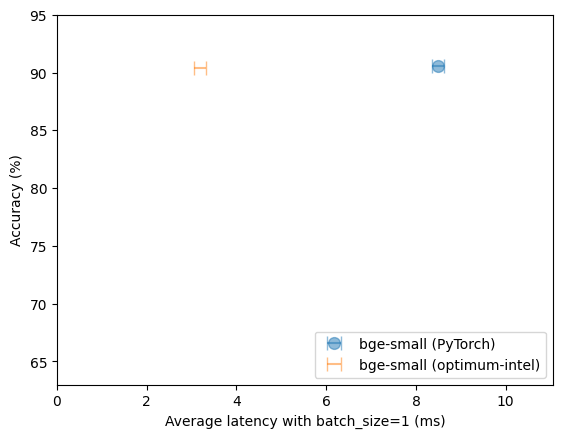

Latency speedup for 'bge-small (optimum-intel)': 2.66x


In [16]:
pb = PerformanceBenchmark(
    optimum_setfit_model,
    test_dataset,
    "bge-small (optimum-intel)",
    model_path=optimum_model_path,
)

# Load baseline benchmark results
with open("baseline_metrics.json") as f:
    perf_metrics = json.load(f)
perf_metrics.update(pb.run_benchmark())

# Print all results
print()
for optim_type, results in perf_metrics.items():
    s = [f"{k}: {v:.3f}" for k, v in results.items()]
    print(f"{optim_type}:\n" + "\n".join(s) + "\n")
    
plot_metrics(perf_metrics)

def get_latency_speedup(model_name):
    speedup = perf_metrics['bge-small (PyTorch)']['time_avg_ms'] / perf_metrics[model_name]['time_avg_ms']
    return speedup
print(f"Latency speedup for 'bge-small (optimum-intel)': {get_latency_speedup('bge-small (optimum-intel)'):.2f}x")